# Metric: Walkability
### By Brandon McCoy
Walkability refers to how easy and pleasant it is to walk in a particular area, taking into account factors like pedestrian safety, access to amentities, and sidewalk quality. To help determine this metric, I'm going to use a dataset titled "Allegheny County Walk Scores", which provides a walkscore for each tract based on walking routes to nearby amentities and pedestrian friendliness (which is determined by population density and road metrics like block length and intersection density). 

To get started, lets load in the data and see what we have:


In [56]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

walkscores = pd.read_csv("Brandon/walkscorect.xls-walk-score-by-ct.csv")

walkscores.head()

,Census Tract,Walk Score
0,10300,82
1,20100,100
2,20300,83
3,30500,77
4,40200,71


While this is helpful, the census tract isn't a great descriptor for the neighborhood. To fix this, lets create a dictionary that maps each tract to it's respective neighborhood name and then combine those into another dataset. This will require another dataset called "2010 Census Tracts". 

In [57]:
tracts = pd.read_csv("Brandon/9756af5f-3320-4601-84e2-347d64071e25.csv")
tracts.head()

,objectid,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,aland10,...,objectid_1,tractce10_1,cnt_tractce10,sum_lowmod2018,sum_lowmoduniv,lowmodperct,lowmodpercanno,cdbg2018,shape_area,shape_length
0,1,42,3,40500,1,420030405001,Block Group 1,G5030,S,268195,...,7,40500,2,2775,2985,92.964824,92.96,Yes,5.079492e+06,10442.036450
1,2,42,3,40400,1,420030404001,Block Group 1,G5030,S,75472,...,6,40400,2,1365,2020,67.574257,67.57,Yes,2.105489e+06,6609.688123
2,3,42,3,40200,2,420030402002,Block Group 2,G5030,S,282679,...,5,40200,2,1070,1290,82.945736,82.94,Yes,5.998649e+06,18280.484081
3,4,42,3,30500,2,420030305002,Block Group 2,G5030,S,284548,...,4,30500,2,1635,2130,76.760563,76.76,Yes,7.203631e+06,15694.771444
4,5,42,3,980000,1,420039800001,Block Group 1,G5030,S,637235,...,125,980000,1,65,220,29.545455,29.54,No,7.764866e+06,13581.875089


Next, I'm going to create the dictionary that links each tract to it's corresponding neighborhood name

In [58]:
neighborhood_names = zip(tracts.tractce10, tracts.hood)
neighborhood_names = list(neighborhood_names)
neighborhood_names = dict(neighborhood_names)
print(neighborhood_names)

{40500: 'Central Oakland', 40400: 'North Oakland', 40200: 'West Oakland', 30500: 'Crawford-Roberts', 980000: 'Lincoln-Lemington-Belmar', 20300: 'Strip District', 20100: 'Central Business District', 262000: 'Spring Hill-City View', 261500: 'Perry South', 261400: 'Perry South', 261200: 'Summer Hill', 260900: 'Northview Heights', 260700: 'Perry North', 563100: 'Westwood', 562400: 'Beltzhoover', 981000: 'Central Lawrenceville', 170200: 'South Side Flats', 180300: 'Allentown', 170600: 'South Side Slopes', 10300: 'Bluff', 260200: 'Perry North', 180700: 'Mount Washington', 250900: 'Fineview', 562900: 'Hazelwood', 561900: 'Lincoln-Lemington-Belmar', 130600: 'East Hills', 40900: 'South Oakland', 562300: 'Hazelwood', 151700: 'Greenfield', 151600: 'Greenfield', 141400: 'Squirrel Hill South', 141300: 'Squirrel Hill South', 250300: 'Central Northside', 241200: 'Spring Garden', 562000: 'North Oakland', 80900: 'Bloomfield', 240600: 'Troy Hill', 220600: 'Central Northside', 981800: 'Lincoln-Lemington-

Using that dictionary, lets add a "Neighborhood" column into the original dataset using the map function

In [59]:
walkscores['Neighborhood'] = walkscores['Census Tract'].map(neighborhood_names)

walkscores.head(10)

,Census Tract,Walk Score,Neighborhood
0,10300,82,Bluff
1,20100,100,Central Business District
2,20300,83,Strip District
3,30500,77,Crawford-Roberts
4,40200,71,West Oakland
5,40400,82,North Oakland
6,40500,78,Central Oakland
7,40600,75,Central Oakland
8,40900,68,South Oakland
9,50100,60,Middle Hill


Since the orignal dataset on walkability included all neighborhoods in Allegheny County, lets remove the ones outside of city limits since we're focusing on Pittsburgh only. This will be easy to determine since the dataset I used to get the neighborhood names only included the ones inside city limits. When I merged the two, this resulted in the tracts outside of Pittsburgh not having a value in the dictionary, which ended up with some rows in the "Neighborhood" being null. Lets remove those rows.

In [60]:
walkscores = walkscores[walkscores.Neighborhood.notnull()]

In addition, some neighborhoods are composed of multiple tracts which means some of them have more than one row. To fix this, lets remove duplicate neighborhoods and only keep the walkscore of the highest tract for those neighborhoods. 

In [61]:
walkscores = walkscores.sort_values(by='Walk Score', ascending=False)
walkscores = walkscores.groupby('Neighborhood').first().reset_index()
walkscores = walkscores.sort_values(by='Walk Score', ascending=False)
walkscores.head(10)

,Neighborhood,Census Tract,Walk Score
13,Central Business District,20100,100
38,Lower Lawrenceville,60300,91
57,Shadyside,70300,91
15,Central Northside,220600,89
66,Squirrel Hill South,140800,88
55,Polish Hill,60500,88
0,Allegheny West,562700,86
26,Friendship,80700,86
14,Central Lawrenceville,90200,86
23,East Liberty,111500,86


Lets plot the top 15 neighborhoods

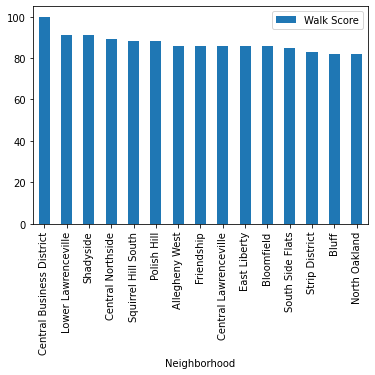

In [62]:
walkscores.head(15).plot.bar(x='Neighborhood', y='Walk Score')

Lets plot the bottom 15 neighborhoods

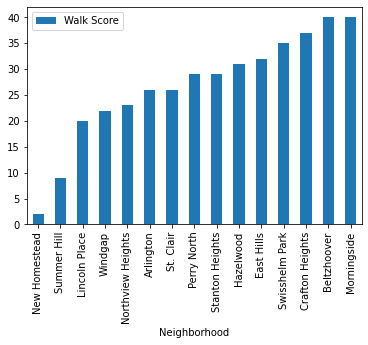

In [63]:
walkscores.sort_values(by='Walk Score').head(15).plot.bar(x="Neighborhood", y="Walk Score")

Lets merge that dataframe with a shape file of Pittsburgh's neighborhoods to get a map represetation of the walkscores around the city.

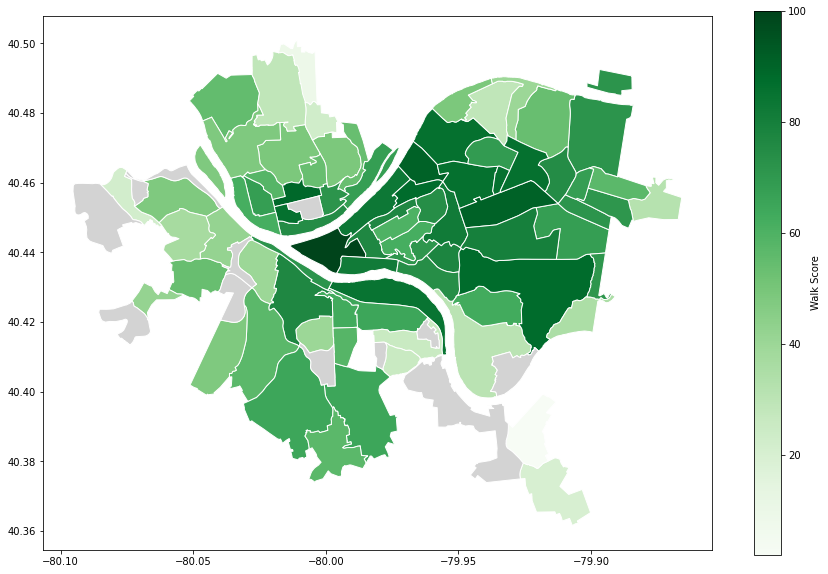

In [64]:
neighborhoods = gpd.read_file('Brandon/Neighborhoods/Neighborhoods_.shp')
walkability_map = neighborhoods.merge(walkscores, how='left', left_on='hood', right_on='Neighborhood')
walkability_map.head()
walkability_map.plot(column='Walk Score', 
               cmap='Greens',                                         # choose a color palette
               edgecolor="white",                                     # outline the districts in white
               legend=True,                                           # show the legend
               legend_kwds={'label': "Walk Score"},                   # label the legend
               figsize=(15, 10),                                      # set the size
               missing_kwds={"color": "lightgrey"}                    # set disctricts with no data to gray
               )